<a href="https://colab.research.google.com/github/adidonner/Machine-Deep-Leap-learning-Python-Based/blob/main/HW4_drones_vs_birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short solution

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import glob
import cv2
import random

In [ ]:
def save_processed_images(folder, label, image_size=(32, 32), other_label='other'):
    """
    Save processed images into folders corresponding to their labels.

    Parameters:
    folder (str): Path to the folder containing images and labels.
    label (str): Label for the images in this folder.
    image_size (tuple): Target size for the images (width, height).
    other_label (str): Label for the 'other' class.
    """
    image_paths = glob.glob(os.path.join(folder, '*.jpg'))[:100]  # Assuming images are in JPG format

    # Create directories for each label if they don't exist
    label_path = '/content/data/' + label
    other_path = '/content/data/' + other_label
    if not os.path.exists(label):
        os.makedirs(label_path, exist_ok=True)
    if not os.path.exists(other_label):
        os.makedirs(other_path, exist_ok=True)

    for i, image_path in enumerate(image_paths):
        # Read image
        image = cv2.imread(image_path)
        img_height, img_width = image.shape[:2]

        # Process for the specified class
        txt_path = image_path.replace('.jpg', '.txt')
        with open(txt_path, 'r') as f:
            bbox = f.readline().split()
            x_center, y_center, width, height = [float(x) for x in bbox[1:]]

            x = int((x_center - width / 2) * img_width)
            y = int((y_center - height / 2) * img_height)
            w = int(width * img_width)
            h = int(height * img_height)

            cropped_img = image[y:y+h, x:x+w]
            resized_img = cv2.resize(cropped_img, image_size)
            save_path = os.path.join(label_path, os.path.basename(image_path))
            cv2.imwrite(save_path, resized_img)

            # Process for 'other' class
            x_rand = random.randint(0, img_width - 32)
            y_rand = random.randint(0, img_height - 32)
            random_crop = image[y_rand:y_rand+32, x_rand:x_rand+32]
            other_save_path = os.path.join(other_path, 'other_' + os.path.basename(image_path))
            cv2.imwrite(other_save_path, random_crop)

        if i%200 == 0:
            print(f'Processed {i+1} {label} and {other_label} images')

bird_path = '/content/drive/MyDrive/Road2_Courses/AI_Course/bird_data' # Change to your real path
drone_path = '/content/drive/MyDrive/Road2_Courses/AI_Course/drone_data' # Change to your real path

bird_data = save_processed_images(bird_path, 'bird')
drone_data = save_processed_images(drone_path, 'drone')

Processed 1 bird and other images
Processed 1 drone and other images


In [ ]:
directory = '/content/data'

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    batch_size=32,
    image_size=(32, 32),
    shuffle=True,
    seed = 5,
    validation_split=0.2,
    subset='training',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    batch_size=32,
    image_size=(32, 32),
    shuffle=False,
    seed = 5,
    validation_split=0.2,
    subset='validation',
)

Found 400 files belonging to 3 classes.
Using 320 files for training.
Found 400 files belonging to 3 classes.
Using 80 files for validation.


## Without augmentation:

In [ ]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_ds, epochs=10, validation_data=val_ds)

# Plot sample images from each class and display the number of examples
# Code to plot images and display class distribution

Epoch 1/10
394/394 [==============================] - 7s 16ms/step - loss: 1.2286 - accuracy: 0.8849 - val_loss: 0.0918 - val_accuracy: 0.9809
Epoch 2/10
394/394 [==============================] - 7s 17ms/step - loss: 0.1816 - accuracy: 0.9424 - val_loss: 0.0475 - val_accuracy: 0.9889
Epoch 3/10
394/394 [==============================] - 6s 16ms/step - loss: 0.1339 - accuracy: 0.9592 - val_loss: 0.0530 - val_accuracy: 0.9882
Epoch 4/10
394/394 [==============================] - 6s 16ms/step - loss: 0.1034 - accuracy: 0.9684 - val_loss: 0.1111 - val_accuracy: 0.9794
Epoch 5/10
394/394 [==============================] - 6s 16ms/step - loss: 0.0869 - accuracy: 0.9734 - val_loss: 0.0640 - val_accuracy: 0.9832
Epoch 6/10
394/394 [==============================] - 6s 16ms/step - loss: 0.0876 - accuracy: 0.9747 - val_loss: 0.0391 - val_accuracy: 0.9936
Epoch 7/10
394/394 [==============================] - 7s 17ms/step - loss: 0.0656 - accuracy: 0.9810 - val_loss: 0.0501 - val_accuracy: 0.9921

We can see the model is perfect and overfitted the data

## Adding two augmentations: flip and rotation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

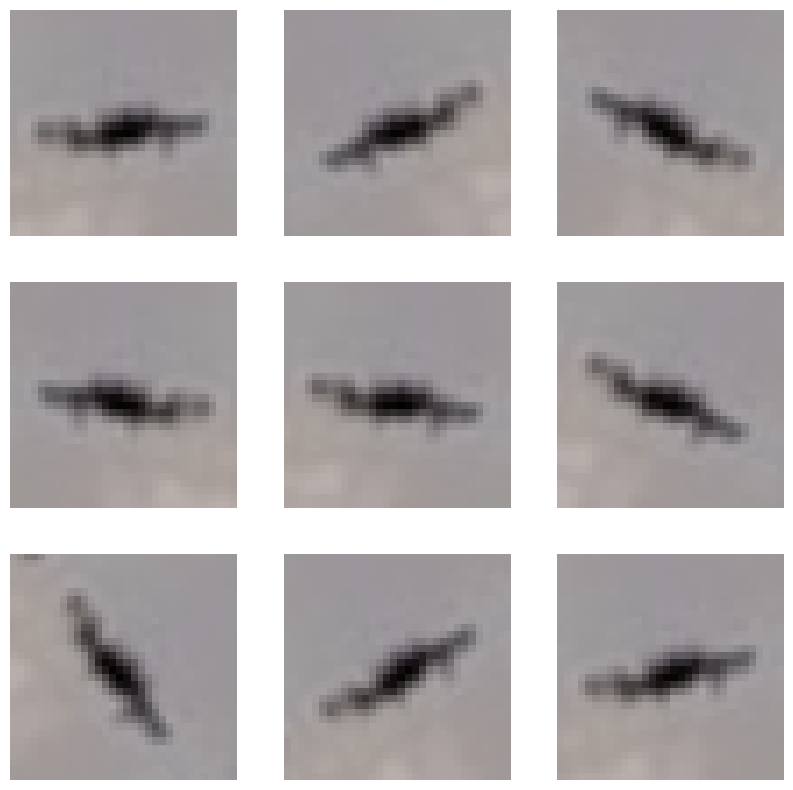

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
# Build CNN model
model = Sequential([
    data_augmentation,
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_ds, epochs=10, validation_data=val_ds)

# Plot sample images from each class and display the number of examples
# Code to plot images and display class distribution

Epoch 1/10
10/10 [==============================] - 4s 32ms/step - loss: 41.2467 - accuracy: 0.3219 - val_loss: 2.8297 - val_accuracy: 0.0375
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 1.9745 - accuracy: 0.6000 - val_loss: 0.3463 - val_accuracy: 0.8125
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 0.7683 - accuracy: 0.7156 - val_loss: 0.1905 - val_accuracy: 0.9875
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 0.4321 - accuracy: 0.8562 - val_loss: 0.1616 - val_accuracy: 0.9500
Epoch 5/10
10/10 [==============================] - 0s 7ms/step - loss: 0.4369 - accuracy: 0.8594 - val_loss: 0.1957 - val_accuracy: 0.9750
Epoch 6/10
10/10 [==============================] - 0s 7ms/step - loss: 0.3884 - accuracy: 0.8625 - val_loss: 0.0726 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 0s 7ms/step - loss: 0.3083 - accuracy: 0.8875 - val_loss: 0.0668 - val_accuracy: 1.0000
Epoch 8/10
10/10 [

In this case, adding only two augmentation helped the model to generelize better